In [2]:
using PyPlot

# Sparse matrices and iterative methods

## Sparse format

Large matrices whose entries are mostly zeros are typically called _sparse_. They can be stored more efficiently than "dense" or full matrices, but must explicitly be constructed as a sparse type.

In [4]:
A = sprandn(10000,10000,0.0004);
whos()

                             A    704 KB     10000×10000 SparseMatrixCSC{Float…
                          Base  36315 KB     Module
                       BinDeps    218 KB     Module
                    ColorTypes   5845 KB     Module
                        Colors    403 KB     Module
                        Compat   5594 KB     Module
                         Conda   5591 KB     Module
                          Core  13918 KB     Module
             FixedPointNumbers     30 KB     Module
                        IJulia   6688 KB     Module
                          JSON   5652 KB     Module
                 JuliaBoxUtils   5502 KB     Module
                  LaTeXStrings   4622 bytes  Module
                    MacroTools   5728 KB     Module
                          Main  47358 KB     Module
                        Nettle   5579 KB     Module
                        PyCall   6446 KB     Module
                        PyPlot   6941 KB     Module
                      Reexport   530

The equivalent full (or "dense") matrix would require 800 MB of storage.

Two common ways to inspect a sparse matrix are nnz, the number of nonzeros, and spy, which shows the locations of the nonzeros.

In [5]:
nnz(A)

40103

In [1]:
spy(A)

LoadError: LoadError: UndefVarError: spy not defined
while loading In[1], in expression starting on line 1

Sparse matrices are not just more memory-efficient; they are able to ignore zeros when taking sums and products.

In [6]:
v = rand(10000,1);
tic() 
for k = 1:100 
    A*v; 
end
toc()

elapsed time: 0.169964934 seconds


0.169964934

In [7]:
F = full(A);
tic()
for k = 1:100
    F*v; 
end
toc()

elapsed time: 28.75442597 seconds


28.75442597

_Nota Bene_: the way a sparse matrix is stored can make column operations a lot faster than row operations.

In [8]:
B = A;
tic()
B[:,1000] = sum(B[:,1:10000],2); 
toc()

elapsed time: 1.271731222 seconds


1.271731222

In [9]:
B = A;
tic()
B[1000,:] = sum(B[1:10000,:],1); 
toc()

elapsed time: 0.823173121 seconds


0.823173121

## Sparse backslash

There are algorithms that attempt to exploit sparsity when solving linear systems of equations. They will be called automatically when backslash is used on a sparse matrix. The time required varies wildly, but these methods can be surprisingly effective, especially for well-known common problems such as the 5-point Laplacian approximation.

In [10]:
n = 499;  
@show m = n^2
o = ones(m);
A = spdiagm((-o[1:m-n],-o[1:m-1],4o,-o[1:m-1],-o[1:m-n]),[-n -1 0 1 n],m,m);
b = ones(m);
tic() 
x = A\b; 
toc()

m = n ^ 2 = 249001
elapsed time: 4.584500911 seconds


4.584500911

Thus a $250000\times 250000$ matrix is not necessarily 'large'!

## Jacobi and Gauss-Seidel

Sooner or later, though, one encounters  $A\mathbf{x}=\mathbf{b}$ problems of a type and size where the sparse direct algorithms take too long. At this point one turns to iterative methods, which can be halted before complete convergence.

A classical iterative idea is to split the matrix additively: $A=M−N$, so that:

$$M\mathbf{x}=N\mathbf{x}+\mathbf{b}.$$

This is turns into a fixed-point iteration:

$$M\mathbf{x}^{(k+1)}=N\mathbf{x}^{(k)}+\mathbf{b}.$$

If $M$ is the "diagonal part" of $A$, this is the **Jacobi** iteration, and if $M$ is the lower triangle of $A$, it is the **Gauss-Seidel** iteration.

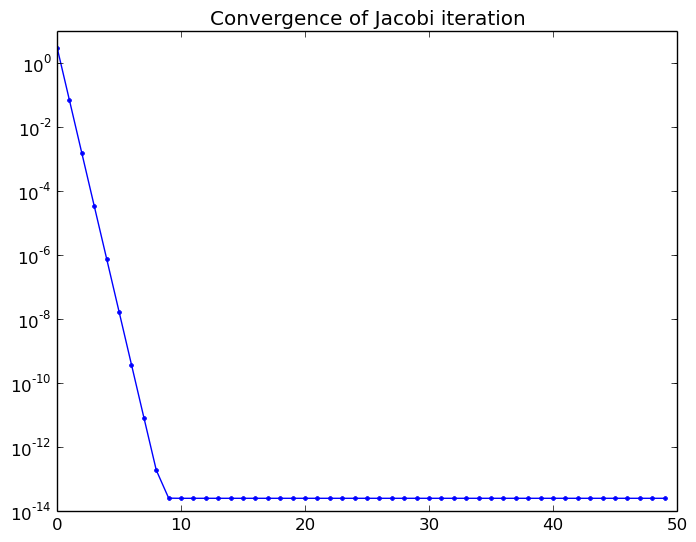

PyObject <matplotlib.text.Text object at 0x7f5647170d90>

In [13]:
m = 20000; A = sprandn(m,m,0.001) + m/100*speye(m); b = ones(m);
dA = diag(A); N = - triu(A,1) - tril(A,-1); x = 0*b; 
normres = [];
for k = 1:50
    x = (N*x + b)./dA;
    normres = [normres;norm(b-A*x)];
end
semilogy(normres,".-"); title("Convergence of Jacobi iteration")

Iterative methods come at a price: the convergence of the method depends very strongly on the matrix $A$, as well as the method chosen. Unlike $LU$ factorization and the related direct methods, these methods are far from "plug-n-play."

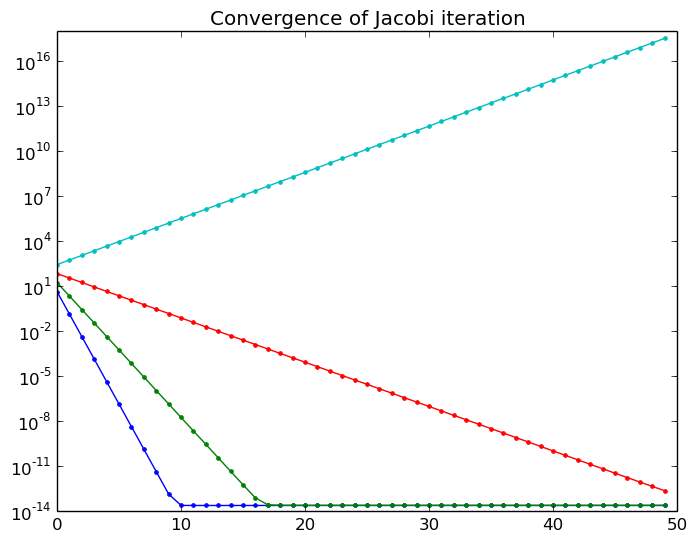

PyObject <matplotlib.text.Text object at 0x7f56470c8410>

In [12]:
mu = sqrt(m);
for i = 1:4
    A = sprandn(m,m,0.001) + mu*speye(m); 
    dA = diag(A); 
    N = - triu(A,1) - tril(A,-1); 
    x = 0*b;
    normres = [];
    for k = 1:50
        x = (N*x + b)./dA;
        normres = [normres;norm(b-A*x)];
    end
    semilogy(normres,".-")
    mu = mu/4;
end
title("Convergence of Jacobi iteration")

Although Jacobi, Gauss-Seidel, and friends are helpful in some circumstances, they have been largely overtaken by **Krylov subspace methods**. 

They are more robust over a wider range of problems, they allow the incorporation of partial knowledge of the matrix or crude approximate solutions, and they can be used without even needing to know the matrix $A$!

## Matrix-free iterations

A matrix is the expression of a linear transformation on vectors. Krylov subspace methods require the matrix $A$ only in the form, "find  $A\mathbf{v}$ given any vector $\mathbf{v}$." That is, any representation of the linear transformation is just as good as having the matrix.

For instance, consider the _PageRank_ algorithm that made Google the king of the internet search. PageRank represents the web as an undirected graph, or equivalently as a weighted adjacency matrix, where adjacency means a link in one page to another. 

This is an enormous graph that is incredibly sparse. You don't need to worry about representing the adjacency matrix  $A$. Instead, you just need the capability to perform the mapping "given the probability of being on every page, follow links randomly to calculate the probabilities of visiting every page next."

In differential equations, we don't need a matrix representation of a discretized differentiation operator, which could be a headache on 2D or 3D regions. You just need the operation (for example), "find the values of the derivative of an interpolant to these values." This matrix-free viewpoint is often easier to code and faster to compute.